# Welcome to 511 keV imaging with cosipy-classic
In this notebook, we'll use a Richardson-Lucy deconvolution algorithm to image 511 keV emission from the center of the Milky Way Galaxy. This analysis requires significant computer memory (>50 GB), so you may want to use a more resource-intensive computer for this work. Please refer to the README for additional information on each step of the analysis.

## Import packages
We will need to import the cosipy-classic functions from COSIpy_dc1.py, response_dc1, and COSIpy_tools_dc1, as well as some other standard Python packages

In [1]:
from COSIpy_dc1 import *
import response_dc1
from COSIpy_tools_dc1 import *

import pickle
import pystan

Welcome to JupyROOT 6.24/06


/Users/ckierans/Software/COSItools/COSItools/external/root_v6.24.06/lib/ROOT/_facade.py:150: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  return _orig_ihook(name, *args, **kwds)


## Define file names
This file contains the 10X flux 511 keV simulation and Ling BG. 

You can optionally image only 511 keV (without background) by changing this file to the 511 keV-only simulation. You will have to adjust the RL algorithm parameters later in the notebook.

In [16]:
data_dir = '../data_products' # directory containing data & response files
filename = 'GC511_10xFlux_and_Ling.inc1.id1.extracted.tra.gz'# 511 keV with Ling BG
response_filename = data_dir + '/511keV_imaging_response.npz' # detector response
background_filename = data_dir + '/Scaled_Ling_BG_1x.npz' # background response
background_mode = 'from file'

## Read simulation and define analysis object
Read in the data set and create the main cosipy-classic “analysis1" object, which provides various functionalities to study the specified file. This cell usually takes a few minutes to run.

In [5]:
analysis1 = COSIpy(data_dir, filename)
analysis1.read_COSI_DataSet()

# Bin the data
Calling "get_binned_data()" may take several minutes, depending on the size of the dataset and the number of bins. Keep an eye on memory here: if your time bins are very small, for example, this could be an expensive operation.

As currently written, "get_binned_data()" uses about **4 GB memory**.

In [6]:
# Define the bin sizes
Delta_T = 1800 # time bin size in seconds
energy_bin_edges = np.array([501, 521]) # as defined in the response
pixel_size = 6. # as defined in the response

analysis1.dataset.time_binning_tags(time_bin_size=Delta_T)
analysis1.dataset.init_binning(energy_bin_edges=energy_bin_edges, pixel_size=pixel_size) # initiate the binning
analysis1.dataset.get_binned_data() # bin data

## Examine the shape of the binned data.
The binned data are contained in "analysis1.dataset.binned_data." This is a 4-dimensional object representing the 5 dimensions of the Compton data space: (time, energy, $\phi$, FISBEL).

The number of bins in each dimension are shown by calling "shape."

In [7]:
print("time, energy, phi, fisbel")
print(analysis1.dataset.binned_data.shape)


time, energy, phi, fisbel
(2240, 1, 30, 1145)


In [8]:
# Can print the number of time bins, the width of each time bin, and the total time
print(analysis1.dataset.times.n_time_bins)
print(analysis1.dataset.times.times_wid)
print(analysis1.dataset.times.total_time)

2240
[900.         900.         900.         ... 900.         900.
 898.27507758]
4031996.550155163


## Plot raw spectrum & light curve
For a single energy bin, the spectrum is necessarily a top hat in the sole non-zero bin.

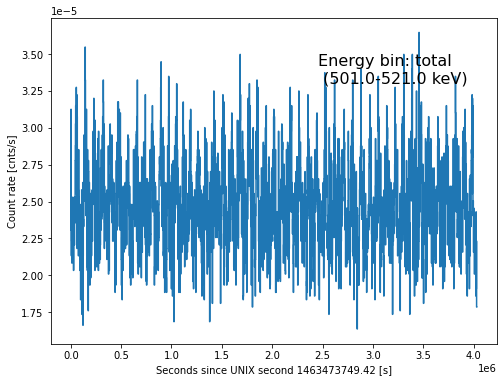

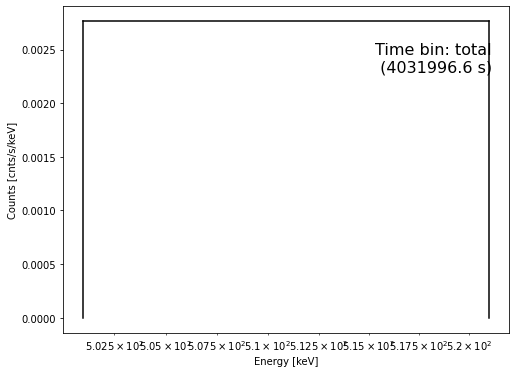

In [11]:
analysis1.dataset.plot_lightcurve()

analysis1.dataset.plot_raw_spectrum()
plt.xscale('log')

# Define the pointing object with the cosipy pointing class.
This may also take several minutes to run.

In [12]:
# definition of poitings (balloon stability + Earth rotation)
pointing1 = Pointing(dataset=analysis1.dataset,)

# Define the BG model

In [13]:
# Ling BG simulation to model atmospheric background
background1 = BG(dataset=analysis1.dataset,mode=background_mode,filename=background_filename)

Using background mode: from file


# Read in the Response Matrix

In [17]:
# 511 keV response
rsp = response_dc1.SkyResponse(filename=response_filename,pixel_size=pixel_size) # read in detector response

Reading complete continuum response. This might take a while...
Done.

You probably used a line response, there is no RMF.
If not, think again.
Done.

Creating general IRF. Wait for it...
Done.

Deleting full matrix.
Done. Now have fun.


## Exploring the shape of the data space
The shape of the response spans (Galactic latitude $b$, Galactic longitude $\ell$, Compton scattering angle $\phi$,  FISBEL, energy). There is 1 energy bin for the 511 keV response ("analysis1.dataset.energies.n_energy_bins"). This is why there is no fifth dimension for the energy printed below. The shape of the data and background objects span (time, Compton scattering angle, FISBEL).

In [18]:
rsp.rsp.response_grid_normed_efinal.shape

(30, 60, 30, 1145)

In [19]:
np.shape(analysis1.dataset.binned_data)

(2240, 1, 30, 1145)

In [20]:
np.shape(background1.bg_model)

(2240, 1, 30, 1145)

# Imaging Setup

## Define a grid on the sky to make images

In [22]:
# Convenient variable for deg --> radian conversion
deg2rad = np.pi/180.

# We define our sky-grid on a regular (pixel_size x pixel_size) grid for testing (later finer grid)
binsize = pixel_size

# Galactic coordiantes: l and b pixel edges
l_arrg = np.linspace(-180, 180, int(360/binsize)+1)
b_arrg = np.linspace(-90, 90, int(180/binsize)+1)

# Number of pixels in l and b
n_l = int(360/binsize)
n_b = int(180/binsize)

# Making a grid
L_ARRg, B_ARRg = np.meshgrid(l_arrg, b_arrg)

# Choosing the centre points as representative
l_arr = l_arrg[0:-1] + binsize/2
b_arr = b_arrg[0:-1] + binsize/2
L_ARR, B_ARR = np.meshgrid(l_arr, b_arr)

# Define solid angle for each pixel for normalisations later
domega = (binsize*deg2rad)*(np.sin(np.deg2rad(B_ARR + binsize/2)) - np.sin(np.deg2rad(B_ARR - binsize/2)))

## Convert sky grid to zenith/azimuth pairs for all pointings

In [23]:
# calculate the zeniths and azimuths on that grid for all times
zensgrid,azisgrid = zenaziGrid(pointing1.ypoins[:,0], pointing1.ypoins[:,1],
                               pointing1.xpoins[:,0], pointing1.xpoins[:,1],
                               pointing1.zpoins[:,0], pointing1.zpoins[:,1],
                               L_ARR.ravel(), B_ARR.ravel())

In [24]:
# Reshape for next routines ... 
zensgrid = zensgrid.reshape(n_b, n_l, len(pointing1.xpoins))
azisgrid = azisgrid.reshape(n_b, n_l, len(pointing1.xpoins))

## Get observation indices for non-zero bins

In [25]:
# Choose an energy bin to analyze
ebin = 0 # We only have one energy bin (501-521 keV), so the index is necessarily 0.
nonzero_idx = background1.calc_this[ebin]


## Reduce the response dimensions

In [27]:
sky_response_CDS = rsp.rsp.response_grid_normed_efinal.reshape(
    n_b,
    n_l,
    analysis1.dataset.phis.n_phi_bins*\
    analysis1.dataset.fisbels.n_fisbel_bins, analysis1.dataset.energies.n_energy_bins)[:, :, nonzero_idx, ebin]

In [ ]:
# reduced response dimensions:
# lat x lon x CDS
sky_response_CDS.shape

## Function to get the response of an image for arbitrary time binning

In [26]:
def get_image_response_from_pixelhit_general(Response,zenith,azimuth,dt,n_hours,binsize=6,cut=60,altitude_correction=False,al=None):
    """
    Get Compton response from hit pixel for each zenith/azimuth vector(!) input.
    Binsize determines regular(!!!) sky coordinate grid in degrees.

    :param: zenith        Zenith positions of all points of predefined sky grid with
                          respect to the instrument (in deg)
    :param: azimuth       Azimuth positions of all points of predefined sky grid with
                          respect to the instrument (in deg)
    :option: binsize      Default 5 deg (matching the sky dimension of the response). If set
                          differently, make sure it matches the sky dimension as otherwise,
                          false results may be returned
    :option: cut          Threshold to cut the response calculation after a certain zenith angle.
                          Default 60
    :param: n_hours       Number of hours in cdxervation
    :option: altitude_correction Default False: use interpolated transmission probability, normalised to 33 km and 500 keV,
                          to modify number of expected photons as a function of altitude and zenith angle of cdxervation
    :option: al           Altitude values according to dt from construct_pointings(); used of altitude_correction is set to True
    """

    # assuming useful input:
    # azimuthal angle is periodic in the range [0,360[
    # zenith ranges from [0,180[

    # check which pixel (index) was hit on regular grid
    hit_pixel_zi = np.floor(zenith/binsize)
    hit_pixel_ai = np.floor(azimuth/binsize)

    # and which pixel centre
    hit_pixel_z = (hit_pixel_zi+0.5)*binsize
    hit_pixel_a = (hit_pixel_ai+0.5)*binsize

    # check which zeniths are beyond threshold
    bad_idx = np.where(hit_pixel_z > cut)

    # set hit pixels to output array
    za_idx = np.array([hit_pixel_zi,hit_pixel_ai]).astype(int)

    nz = zenith.shape[2]

    n_lon = int(360/binsize)
    n_lat = int(180/binsize)
    
    l_arrg = np.linspace(-180,180,int(360/binsize)+1)
    b_arrg = np.linspace(-90,90,int(180/binsize)+1)
    L_ARRg, B_ARRg = np.meshgrid(l_arrg,b_arrg)
    l_arr = l_arrg[0:-1]+binsize/2
    b_arr = b_arrg[0:-1]+binsize/2
    L_ARR, B_ARR = np.meshgrid(l_arr,b_arr)

    # take care of regular grid by applying weighting with latitude
    weights = ((binsize*np.pi/180)*(np.sin(np.deg2rad(B_ARR+binsize/2)) - np.sin(np.deg2rad(B_ARR-binsize/2)))).repeat(nz).reshape(n_lat,n_lon,nz)
    weights[bad_idx] = 0

    
    # check for negative weights and indices and remove
    weights[za_idx[0,:] < 0] = 0.
    weights[za_idx[1,:] < 0] = 0.
    za_idx[0,za_idx[0,:] < 0] = 0.
    za_idx[1,za_idx[1,:] < 0] = 0.
        
    
    if altitude_correction == True:
        altitude_response = return_altitude_response()
    else:
        altitude_response = one_func

    # get responses at pixels    
    image_response = np.zeros((n_hours,n_lat,n_lon,Response.shape[2]))

    for c in tqdm(range(n_hours)):
        cdx = np.where((pointing1.cdtpoins > analysis1.dataset.times.times_min[analysis1.dataset.times.n_ph_dx[c]]) &
                       (pointing1.cdtpoins <= analysis1.dataset.times.times_max[analysis1.dataset.times.n_ph_dx[c]]))[0]
    
        # this calculation is basically a look-up of the response entries. In general, weighting (integration) with the true shape can be introduced, however with a lot more computation time (Simpson's rule in 2D ...)
        image_response[c,:,:,:] += np.sum(Response[za_idx[0,:,:,cdx],za_idx[1,:,:,cdx],:]*np.einsum('klij->iklj', weights[:,:,cdx,None])*dt[cdx,None,None,None],axis=0)#*altitude_weights[:,:,None]
        
    return image_response


## Calculate the general response for the current data set
This has to be done only once (for the data set).

Takes ~20 minutes to run and ~60 GB memory!

In [ ]:
cut = 90 # This mirrors the earth horizon cut in the response
sky_response_scaled = get_image_response_from_pixelhit_general(
    Response=sky_response_CDS,
    zenith=zensgrid,
    azimuth=azisgrid,
    dt=pointing1.dtpoins,
    n_hours=analysis1.dataset.times.n_ph,
    binsize=pixel_size,
    cut=cut,
    altitude_correction=False,
    al=np.ones(len(pointing1.dtpoins)))

  0%|          | 0/2240 [00:00<?, ?it/s]

In [30]:
# data-set-specific response dimensions
# times x lat x lon x CDS
sky_response_scaled.shape

(2240, 30, 60, 2314)

## Exposure map
i.e. the response weighted by time

In [31]:
expo_map = np.zeros((n_b, n_l))

for i in tqdm(range(sky_response_scaled.shape[0])):
    expo_map += np.sum(sky_response_scaled[i,:,:,:], axis=2)
    
print(f'expo_map shape: {expo_map.shape}')

  0%|          | 0/2240 [00:00<?, ?it/s]

expo_map shape: (30, 60)


## Plotting the exposure map weighted with the pixel size

In [ ]:
plt.subplot(projection='aitoff')
p = plt.pcolormesh(L_ARRg*deg2rad,B_ARRg*deg2rad,np.roll(expo_map/domega,axis=1,shift=0))
plt.contour(L_ARR*deg2rad,B_ARR*deg2rad,np.roll(expo_map/domega,axis=1,shift=0),colors='black')
plt.colorbar(p, orientation='horizontal')

# Set up the RL algorithm

### Define regions of the sky that we actually cannot see

In [ ]:
# here we select everything, i.e. we have no bad exposure

bad_expo = np.where(expo_map/domega <= 0)

### Define function for a starting map for the RL deconvolution. We choose an isotropic map, i.e. all pixels on the sky are initialized with the same value

In [ ]:
def IsoMap(ll,bb,A0,binsize=pixel_size):
    shape = np.ones(ll.shape)
    norm = np.sum(shape*(binsize*np.pi/180)*(np.sin(np.deg2rad(bb+binsize/2)) - np.sin(np.deg2rad(bb-binsize/2))))
    val = A0*shape/norm
    return val

### Number of time bins (should be the first dimension of the response)

In [ ]:
d2h = n_time_bins 
d2h

### Select only one energy bin (as above) for data set

In [ ]:
print('ebin: ',ebin)
dataset = analysis1.dataset.binned_data[:,ebin,:,:].reshape(d2h,
                                                            analysis1.dataset.phis.n_phi_bins*analysis1.dataset.fisbels.n_fisbel_bins)[:,nonzero_idx]


### Same for background

In [ ]:
background_model = background1.bg_model_reduced[ebin]

### Check for consistency of data and background
They must have the same dimensions. If not, the algorithm won't work.

In [ ]:
dataset.shape,background_model.shape

### Define background model cuts, indices, and resulting number of cuts

In [ ]:
bg_cuts, idx_arr, Ncuts = background1.bg_cuts, background1.idx_arr, background1.Ncuts

### For the modified RL algorithm implemented here, we need to load a stan model that fits background plus two images (the current image plus a delta image given by the RL formalism)


In [ ]:
try:
    #read stanmodel.pkl (if already compiled)
    model_multimap = pickle.load(open('stanmodel.pkl', 'rb'))

except:
    print('Model not yet compiled, doing that now (might take a while).')
    
    # compile model (if not yet compiled):
    model_multimap = pystan.StanModel('stanmodel.stan')

    with open(data_dir + 'stanmodel.pkl', 'wb') as f:
        pickle.dump(model_multimap, f)


## Set an initial guess for the background amplitude
Feel free to play with this value, but here are suggestions informed by testing thus far:

### If source+BG:
We suggest setting "fitted_bg" to 0.9 or 0.99 when the loaded data/simulation (analysis1 object) contains both source and background. This is a rough estimate of the background contribution (90, 99%) to the entire data set.

### If analyzing source only:
When the analysis1 object does not contain background, we suggest setting this parameter to 1E-6, i.e. very close to zero background contribution.

In [ ]:
fitted_bg = np.array([0.99])


# Richardson-Lucy algorithm

## Individual steps are explained in code.
The steps follow the algorithm as outlined in [Knödlseder et al. 1999](https://ui.adsabs.harvard.edu/abs/1999A%26A...345..813K/abstract). Refer to that paper for a mathematical description of the algorithm.

The total memory used during these iterations is about 74 GB!! You might not be able to do much else with your machine while this is running. 

In [ ]:
# Might not use this depending on if you choose to smooth the delta map
from scipy.ndimage import gaussian_filter

In [ ]:
# Experiment with these variables!
#############################
# initial map (isotropic flat, small value)
map_init = IsoMap(L_ARR, B_ARR, 0.01)

# number of RL iterations, Usually test with ~50 iterations, and we can get fully conveerged images with ~150 iterations. 
iterations = 150 

# acceleration parameter
afl_scl = 1000.
#############################


## Define background (to be sure it's the same as before)
bg_cuts, idx_arr, Ncuts = background1.bg_cuts, background1.idx_arr, background1.Ncuts
 
    
## Save intermediate iterations: initialise arrays to save images and other parameters
# maps per iteration
map_iterations = np.zeros((n_b, n_l, iterations))

# likelihood of maps (vs. initial i.e. basically only background)
map_likelihoods = np.zeros(iterations)

# fit likelihoods, ie fit quality
intermediate_lp = np.zeros(iterations)

# acceleration parameters (lambda)
acc_par = np.zeros(iterations)

# fitted background parameters 
bg_pars = np.zeros((iterations,Ncuts))


## Zeroth iteration: copy initial map to become the 'old map' (see below)
map_old = map_init

# cf. Knoedlseder+1997 what the values denominator etc are
# this is the response R summed over the CDS and the time bins
denominator = expo_map

# zeroth iteration is then just the initial map
map_iterations[:,:,0] = map_old#[]

# convolve this map with the response
expectation_init = 0
print('Convolving with response (init expectation), iteration 0')
for i in tqdm(range(n_b)):
    for j in range(n_l):
        expectation_init += sky_response_scaled[:,i,j,:]*map_init[i,j]

# set old expectation (in data space bins) to new expectation (convolved image)
expectation_old = expectation_init

### now we have the expectation of the image. Need to go to the BG 
        
###########################################################
###########################################################
## here run over the number of iterations #################
###########################################################
## the time for the convolutions is very large ############
## this can be 10 minutes (!) per iteration ###############
## this should be tested for a few iterations #############
## and then run overnight or similar ######################
###########################################################
###########################################################
for its in tqdm(range(1,iterations)):
    
    # setting the map to zero where we selected a bad exposure (we didn't, but to keep it general)
    map_old[bad_expo[0],bad_expo[1]] = 0
    
    # check for each pixel to be finite
    map_old[np.where(np.isnan(map_old) == True)] = 0
    
    # make new background for the next iteration
    bg_cuts, idx_arr, Ncuts = background1.bg_cuts, background1.idx_arr, background1.Ncuts
    
    # temporary background model
    tmp_model_bg = np.zeros((d2h,background1.bg_model_reduced[ebin].shape[1]))
    
    # there could be something different for the first iteration (here it isn't, same function call)
    if its == 1:
        for g in range(d2h):
            tmp_model_bg[g,:] = background_model[g,:]*fitted_bg[idx_arr-1][g]
    else:
        for g in range(d2h):
            tmp_model_bg[g,:] = background_model[g,:]*fitted_bg[idx_arr-1][g]
            
    # expectation (in data space) is the image (expectation_old) plus the background (tmp_model_bg)
    expectation_tot_old = expectation_old + tmp_model_bg 

    # calculate likelihood of currect total expectation
    map_likelihoods[its-1] = cashstat(dataset.ravel(),expectation_tot_old.ravel())
    
    # calculate numerator of RL algorithm
    numerator = 0
    print('Calculating Delta image, iteration '+str(its)+', numerator')
    for i in tqdm(range(d2h)):
        for j in range(dataset.shape[1]):
            numerator += (dataset[i,j]/expectation_tot_old[i,j]-1)*sky_response_scaled[i,:,:,j]
    
    # calculate delta map (denominator scaled by fourth root to avoid exposure edge effects)
    # You can try changing 0.25 to 0, 0.5, for example
    delta_map_tot_old = (numerator/denominator)*map_old*(denominator)**0.25
    
    # Alternatively, you can also try to smooth it 
    #delta_map_tot_old = gaussian_filter(delta_map_tot_old, 0.5)
    
    #################################
    
    
    
    # check again for finite values and zero our bad exposure regions
    nan_idx = np.where(np.isnan(delta_map_tot_old) == 1)
    delta_map_tot_old[nan_idx[0],nan_idx[1]] = 0
    delta_map_tot_old[bad_expo[0],bad_expo[1]] = 0

    # plot each iterations and its delta map 
    # (not required, but nice to see how the algorithm is doing)
    plt.figure(figsize=(16,6))
    plt.subplot(121)
    plt.pcolormesh(L_ARRg,B_ARRg,np.roll(map_old, axis=1, shift=0)) 
    plt.colorbar()

    plt.subplot(122)
    plt.pcolormesh(L_ARRg,B_ARRg,np.roll(delta_map_tot_old, axis=1, shift=0)) 
    plt.colorbar()
    plt.show()
    
    # convolve delta image
    print('Convolving Delta image, iteration '+str(its))
    conv_delta_map_tot = 0
    for i in tqdm(range(n_b)):
        for j in range(n_l):
            conv_delta_map_tot += sky_response_scaled[:,i,j,:]*delta_map_tot_old[i,j]
    
    # find maximum acceleration parameter to multiply delta image with
    # so that the total image is still positive everywhere
    print('Finding maximum acceleration parameter, iteration '+str(its))
    try:
        len_arr = []
        for i in range(0,10000):
            len_arr.append(len(np.where((map_old+delta_map_tot_old*i/afl_scl) < 0)[0]))
        len_arr = np.array(len_arr)
        afl = np.max(np.where(len_arr == 0)[0])
        print('Maximum acceleration parameter found: ',afl/afl_scl)

        
        # fit delta map and current map to speed up RL algorithm
        print('Fitting delta-map in addition to old map, iteration '+str(its))
        # dictionary for data set and prior
        # note that here the value for N should be your response CDS dimension
        # should be last dimension of the scaled response thing (change to your value)
        data_multimap = dict(N = dataset.shape[1],
                     Nh = d2h,
                     Ncuts = Ncuts,
                     Nsky = 2,
                     acceleration_factor_limit=afl*0.95,
                     bg_cuts = bg_cuts,
                     bg_idx_arr = idx_arr,
                     y = dataset.ravel().astype(int),
                     bg_model = tmp_model_bg,
                     conv_sky = np.concatenate([[expectation_old],[conv_delta_map_tot/afl_scl]]),
                     mu_flux = np.array([1,afl/2]),
                     sigma_flux = np.array([1e-2,afl]),
                     mu_Abg = fitted_bg,    # can play with this
                     sigma_Abg = fitted_bg) # can play with this

        # fit;
        # initial values for fit (somewhat sensitive here with COSI data)
        init = {}
        init['flux'] = np.array([1.,afl/2.])
        init['Abg'] = np.repeat(fitted_bg, Ncuts) # can play with this
        
        # fit: might take some time but it shouldn't be more than a minute
        op2D = model_multimap.optimizing(data=data_multimap,init=init,as_vector=False,verbose=True,
                                                tol_rel_grad=1e3,tol_obj=1e-20)

        # save values
        print('Saving new map, and fitted parameters, iteration '+str(its))
        intermediate_lp[its-1] = op2D['value']
        acc_par[its-1] = op2D['par']['flux'][1]
        bg_pars[its-1,:] = op2D['par']['Abg']
  
        # make new map as old map plus scaled delta map
        map_new = map_old+op2D['par']['flux'][1]*delta_map_tot_old/afl_scl
    
        # same with expectation (data space)
        expectation_new = expectation_old + op2D['par']['flux'][1]*conv_delta_map_tot/afl_scl
        

    except:
        # if the fit failed...
        # this shouldn't happen too often (or at all)
        print('############## Fit failed! proceeding without acceleration ##############')
        map_new = map_old + delta_map_tot_old
        expectation_new = expectation_old + conv_delta_map_tot
    
    # check finite values again
    if its == 1:
        bad_index_init = np.where(np.isnan(map_new) == True)
    
    # also here
    map_new[bad_expo[0],bad_expo[1]] = 0
    map_new[np.where(np.isnan(map_new) == True)] = 0
    map_iterations[:,:,its] = map_new

    # swap maps
    map_old = map_new
    
    # and expectations
    expectation_old = expectation_new
    
    # and repeat


## Plot the fitted background parameter and the map flux

In [ ]:
plt.figure(figsize=(14,6))
plt.subplot(121)
plt.plot(range(its), [i[0] for i in bg_pars[:its]], '.-')
plt.xlabel('Iteration')
plt.ylabel('BG params]')


plt.subplot(122)
map_fluxes = np.zeros(its)
for i in range(its):
    map_fluxes[i] = np.sum(map_iterations[:,:,i]*domega)
    
plt.plot(map_fluxes[:its],'o-')
plt.xlabel('Iteration')
plt.ylabel('Flux')# [ph/keV]')

## Did the algorithm converge? Look at the likelihoods.
intermediate_lp: Fit likelihoods, i.e. fit quality

map_likelihoods: likelihood of maps (vs. initial i.e. basically only background)

In [ ]:
plt.figure(figsize=(14,6))
plt.subplot(121)
plt.plot(range(its+1)[:-1], intermediate_lp[:its+1][:-1], '.-')
plt.xlabel('Iteration')
plt.ylabel('likelihood (intermediate_lp)')

plt.subplot(122)
plt.plot(range(its+1)[:-1], map_likelihoods[:its+1][:-1], '.-')
plt.xlabel('Iteration')
plt.ylabel('likelihood (map_likelihoods)')


## Make the image!
You can loop over all iterations to make a GIF or just show one iteration (usually the final iteration).

In [ ]:
from IPython.display import Image
from IPython.display import Video
from tqdm.autonotebook import tqdm

from matplotlib import animation

from matplotlib import colors

from scipy.ndimage import gaussian_filter as smooth

In [ ]:
# Choose an image to plot
idx = its 


In [ ]:
# Choose a color map like viridis (matplotlib default), nipy_spectral, twilight_shifted, etc. Not jet.
cmap = plt.get_cmap('viridis') 

# Bad exposures will be gray
cmap.set_bad('lightgray')


##################
# Select here which pixels should be gray
map_iterations_nan = np.copy(map_iterations)

# Select also non-zero exposures here to be gray (avoiding the edge effects)
# You can play with this. Most success in testing with 1e4, 1e3
bad_expo = np.where(expo_map/domega <= 1e4) 

for i in range(iterations):
    map_iterations_nan[bad_expo[0], bad_expo[1], i] = np.nan
#################    


# Set up the plot
fig, ax = plt.subplots(figsize=(10.24,7.68), subplot_kw={'projection':'aitoff'}, nrows=1, ncols=1)

ax.set_xticks(np.array([-120,-60,0,60,120])*deg2rad)
ax.set_xticklabels([r'$-120^{\circ}$'+'\n',
                            r'$-60^{\circ}$'+'\n',
                            r'$0^{\circ}$'+'\n',
                            r'$60^{\circ}$'+'\n',
                            r'$120^{\circ}$'+'\n'])
ax.tick_params(axis='x', colors='orange')

ax.set_yticks(np.array([-60,-30,0,30,60])*deg2rad)
ax.tick_params(axis='y', colors='orange')

plt.xlabel('Gal. Lon. [deg]')
plt.ylabel('Gal. Lat. [deg]')



# "ims" is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame
ims = []


# If you want to make a GIF of all iterations:
#for i in range(iterations):

# If you only want to plot one image:
for i in [idx]:

    ttl = plt.text(0.5, 1.01, f'RL iteration {i}', horizontalalignment='center', 
                   verticalalignment='bottom', transform=ax.transAxes)
    
    # Either gray-out bad exposure (map_iterations_nan) or don't mask (map_iterations)
    # Masking out bad exposure 
    #image = map_iterations_nan[:, :, i]
    image = map_iterations[:, :, i]

    
    img = ax.pcolormesh(L_ARRg*deg2rad,B_ARRg*deg2rad,
                        
                        # Can shift the image along longitude. Here, no shift.
                        np.roll(image, axis=1, shift=0),
            
                        # Optionally smooth with gaussian filter
                        #smooth(np.roll(image, axis=1, shift=0), 0.75/pixel_size),
                        
                        cmap=plt.cm.viridis,
                        
                        # Optionally set the color scale. Default: linear
                        #norm=colors.PowerNorm(0.33)
                       )
    ax.grid()
    
    ims.append([img, ttl])

cbar = fig.colorbar(img, orientation='horizontal')
#cbar.ax.set_xlabel(r'Flux [10$^{-2}$ ph cm$^{-2}$ s$^{-1}$]')
    

# Can save a sole image as a PDF 
#plt.savefig(data_dir + f'images/511keV_RL_image_iteration{idx}.pdf', bbox_inches='tight')
    
    
# # Can save all iterations as a GIF
# ani = animation.ArtistAnimation(fig, ims, interval=200, blit=True, repeat_delay=0)
# ani.save(f'/home/jacqueline/511keV_RL_image_{idx}iterations.gif')


# What do we see?

We clearly see the "bulge" emission of positron-electron annihilation at the center of the Milky Way. This was also seen in the published image of real COSI-balloon flight data [(Siegert et al. 2020)](https://iopscience.iop.org/article/10.3847/1538-4357/ab9607/meta):

<img width="600" alt="Siegert_2020_COSI_511keV" src="https://user-images.githubusercontent.com/33991471/196853486-68a90111-245b-442d-841c-756f47c9c14f.png">


The extended disk emission seen in the SPI image above is not visible here. This is expected; SPI saw about 1 photon per week from the disk and has over a decade of observation time. There is not enough data in the 46-day balloon flight to image the disk.

However, we can still probe the emission morphology of the bulge by fitting a 2-D Gaussian, for example, to our simulated image. Constraining the parameters of this fit is important for modeling the physics (positron propogation, point sources of positrons, etc.) behind this enduring mystery.  

## Fit a 2D Gaussian to the emission

In [ ]:
def gauss_2d(xtuple, A, x0, y0, sigma_x, sigma_y, theta):
    # theta: rotate the blob by positive, counterclockwise angle theta
    (x, y) = xtuple
    x0 = float(x0)
    y0 = float(y0)
    a = np.cos(theta)**2/(2*sigma_x**2) + np.sin(theta)**2/(2*sigma_y**2)
    b = np.sin(2*theta)/(4*sigma_x**2) - np.sin(2*theta)/(4*sigma_y**2)
    c = np.sin(theta)**2/(2*sigma_x**2) + np.cos(theta)**2/(2*sigma_y**2)
    tot = A*np.exp( -( a*(x-x0)**2 + 2*b*(x-x0)*(y-y0) + c*(y-y0)**2 ) )
    return tot.ravel()

In [ ]:
import scipy.optimize as opt
initial_guess = (2, 0, 0, 10, 10, 4)
x = (L_ARRg*deg2rad)[:-1, :-1]
y = (B_ARRg*deg2rad)[:-1, :-1]
z = map_iterations_nan[:,:,idx]
nan = np.isnan(z)
z[nan] = 0.
popt, pcov = opt.curve_fit(gauss_2d, (x, y), z.ravel(), p0=initial_guess)

im_fitted = gauss_2d((x, y), *popt)

In [ ]:
fig, ax = plt.subplots(figsize=(10.24,7.68),subplot_kw={'projection':'aitoff'},nrows=1,ncols=1)

ax.set_xticks(np.array([-120,-60,0,60,120])*deg2rad)
ax.tick_params(axis='x', colors='orange')
ax.set_xticklabels([r'$-120^{\circ}$'+'\n',
                            r'$-60^{\circ}$'+'\n',
                            r'$0^{\circ}$'+'\n',
                            r'$60^{\circ}$'+'\n',
                            r'$120^{\circ}$'+'\n'])
ax.set_yticks(np.array([-60,-30,0,30,60])*deg2rad)
ax.tick_params(axis='y', colors='orange')

ax.set_xlabel('Gal. Lon. [deg]')
ax.set_ylabel('Gal. Lat. [deg]')

# Plot original image
ax.pcolormesh(L_ARRg*deg2rad, B_ARRg*deg2rad, z.reshape(len(x), len(x[0])), cmap=plt.cm.viridis)

# Plot contours
num_contours = 2
levels = [np.max(im_fitted)*0.05, np.max(im_fitted)*0.1,
          np.max(im_fitted)*0.5, np.max(im_fitted)*0.8]

#plt.contour(x, y, im_fitted.reshape(len(x), len(x[0])), levels=num_contours, colors='w')

plt.contour(L_ARR*deg2rad, B_ARR*deg2rad, im_fitted.reshape(len(x), len(x[0])), levels = levels, colors='white')

cbar = fig.colorbar(img, orientation='horizontal')
#cbar.ax.set_xlabel(r'Flux [10$^{-2}$ ph cm$^{-2}$ s$^{-1}$]')
    
ax.grid()

In [ ]:
print('A:', popt[0])
print('x0 [deg]:', popt[1]*180/np.pi)
print('y0 [deg]:', popt[2]*180/np.pi)
print('sigma_x [deg]:', popt[3]*180/np.pi, '--> FWHM_x [deg]:', 2*np.sqrt(2*np.log(2))*popt[3]*180/np.pi)
print('sigma_y [deg]:', popt[4]*180/np.pi, '--> FWHM_y [deg]:', 2*np.sqrt(2*np.log(2))*popt[4]*180/np.pi)
print('theta [deg]:', popt[5]*180/np.pi)